In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import pytz
import missingno as msno
import altair as alt


[Shift time for TimeCreatedSystemTime to UTC](#timeshift)
[Join machines to events](#machines_events)


In [2]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')

In [3]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [4]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [5]:
def get_compare_chart(in_data, in_col, in_title):
    """
    # Visualize codes by EventName in df_win['EventName'].

    :param in_data:
    :param in_col:
    :param in_title:
    :return:
    """

    count_df2 = in_data.groupby(in_col).size().reset_index().rename(columns={0: 'count'})
    # Sort order for chart
    count_df2.sort_values('count', ascending=False, inplace=True)
    sort_order = [val for val in count_df2[in_col].unique()]
    out_chart = alt.Chart(count_df2).mark_bar().encode(
        x=alt.X('count:Q'),
        y=alt.Y(in_col + ':N', sort=sort_order),
        tooltip='count:Q'
    ).properties(title=in_title)
    return out_chart


def show_bar_for_win_event(eventname_list, in_df, visualize_attr):
    for eventname in eventname_list:
        current_df = in_df[in_df['EventName'] == eventname]
        out_chart = get_compare_chart(current_df, visualize_attr,
                                      f'Counts of {visualize_attr} types for {eventname} events')
        yield out_chart

In [6]:
# Get the event names
eventnames = df_win['EventName'].unique()
charts = show_bar_for_win_event(eventnames, df_win, 'ProblemSignatureP3')

In [7]:
# current_chart = next(charts)
# current_chart

In [8]:
eventnames

array(['crashpad_exp', 'APPCRASH', 'AppHangB1', 'MoAppHang', 'BEX64',
       'MoAppCrash', 'MoBEX', 'CLR20r3', 'BEX', 'AppHangXProcB1',
       'LiveKernelEvent', 'MoAppHangXProc', 'POFContextAppCrash',
       'ServiceHang', 'CbsPackageServicingFailure2',
       'CriticalProcessFault2', 'crashpad_jserror', 'WUDFVerifierFailure'],
      dtype=object)

In [9]:
print(df_win['ProblemSignatureP3'].str.contains('.dll').sum())
print(len(df_win))

1569
9836



-  crashpad_exp has only .dll EventItems
-  APPCRASH has 1 .dll and many alphanumeric codes
-  AppHangB1 has only hexadecimal codes
-  MoAppHang has IP-style codes
-  BEX64 has only alphanumeric codes
-  MoAppCrash has IP-style codes
-  MoBEX has IP-style codes
-  CLR20r3 has hexadecimal codes
-  BEX has hexadecimal codes
-  AppHangXProcB1 has hexadecimal codes
-  LiveKernelEvent has single numbers, single letters, and (many) alphanumeric codes
-  MoAppHangXProc events has 2 IP-style codes
-  POFContextAppCrash has IP-style codes
-  ServiceHang has IP-style codes
-  CbsPackageServicingFailure2 has IP-style codes
-  CriticalProcessFault2 has 1 alphanumeric code and 1 00000000 code
-  crashpad_jserror has webui-pdf code
-  WUDFVerifierFailure has 'Driver 'code


In [10]:
# COALESCE() in order: https://www.statology.org/pandas-coalesce/
df_win['Combined_dll'] = df_win[['ProblemSignatureP3', 'ProblemSignatureP6']].bfill(axis=1).iloc[:, 0]
df_win['Combined_dll'] = df_win['Combined_dll'].apply(lambda x: x if '.dll' in str(x) else np.nan)
df_win.drop(columns=['ProblemSignatureP3', 'ProblemSignatureP6'], inplace=True)

In [11]:
df_app.rename(
    columns={
        'FaultingApplicationName':'Combined_Application',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'FaultingProcessId':'Combined_ProcessID',
        'ReportId':'Combined_ReportID',
        'FaultingApplicationStartTime':'Combined_StartTime',
        'FaultingModuleName':'Combined_dll'
    },
    inplace=True
)

df_win.rename(
    columns={
        'ProblemSignatureP1_Application':'Combined_Application',
        'ProblemSignatureP2_AppVersion':'Combined_Version',
        'ProblemSignatureP7_ExceptionCode':'Combined_Exception',
        'ReportID':'Combined_ReportID',
        'CabGuid':'CabGUID'
    },
    inplace=True
)

df_hang.rename(
    columns={
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'Program':'Combined_Application',
        'ProgramVersion':'Combined_Version',
        'ProcessID':'Combined_ProcessID',
        'ReportID':'Combined_ReportID',
        'StartTime':'Combined_StartTime'
    },
    inplace=True
)

In [12]:
events = pd.concat([df_app, df_win, df_hang])
events.reset_index(inplace=True)
events.dropna(axis=1, how='all', inplace=True) # Dropping columns with nothing in them.
# msno.matrix(events.iloc[:, 20:], labels=True, fontsize=8)


<a id="machines_events"></a>
# Join events with machines.


In [13]:
machines = pd.read_parquet('../do_not_commit/Datasets/Persist_System_DISC.pq')

In [14]:
# msno.matrix(incs, labels=True, fontsize=8)

In [15]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [16]:
# Join machine name ('Name0') to events by internal date and ClientItemKey (a different, but similar ID for a machine).
# Because events is left, every row will have a TimeCreatedSystemTime.
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'], how='left')

In [17]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

In [18]:
# msno.matrix(machines_events, labels=True, fontsize=8)

In [19]:
# Convert local time values to Central.
def convert_to_cst(df:pd.DataFrame, utc_column_name:str, cst_column_name:str):
    """
    Create a new column in the events dataframe that converts the TimeCreatedSystemTime from UTC to CST.
    (this is necessary because RWB_EFFECTIVE_DATE is in CST)
    """

    # Make sure the UTC column is in datetime format
    df[utc_column_name] = pd.to_datetime(df[utc_column_name])

    # Convert to UTC timezone
    utc_timezone = pytz.timezone('UTC')
    df[utc_column_name] = df[utc_column_name].dt.tz_localize(utc_timezone)

    # Convert to Central Standard Time (CST) timezone
    cst_timezone = pytz.timezone('America/Chicago')
    df[cst_column_name] = df[utc_column_name].dt.tz_convert(cst_timezone)

    # Drop the original UTC column if desired (optional)
    # df.drop(columns=[utc_column_name], inplace=True)

    return df

In [20]:
machines_events = convert_to_cst(machines_events, utc_column_name='TimeCreatedSystemTime', cst_column_name='CreatedSystemTime_CST')
machines_events[['TimeCreatedSystemTime', 'CreatedSystemTime_CST']].sample(5) # Check all times are -05:00 or -06:00 from UTC (Daylight Savings Time).

,TimeCreatedSystemTime,CreatedSystemTime_CST
218173,2023-05-18 12:40:34.953000+00:00,2023-05-18 07:40:34.953000-05:00
266042,2023-04-13 15:53:06.710000+00:00,2023-04-13 10:53:06.710000-05:00
237729,2023-05-02 07:06:24.597000+00:00,2023-05-02 02:06:24.597000-05:00
137712,2023-01-17 22:45:44.883000+00:00,2023-01-17 16:45:44.883000-06:00
174843,2023-06-20 13:18:37.710000+00:00,2023-06-20 08:18:37.710000-05:00


In [21]:
# Convert the TimeCreatedSystemTime CST column from Datetime to a date datatype (formatted like YYYY-MM-DD).
machines_events['CreatedSystemTime_CST_formatted'] = machines_events['CreatedSystemTime_CST'].dt.strftime('%Y-%m-%d')
machines_events['CreatedSystemTime_CST_formatted'][0]

'2023-04-10'


# Join Boot events with machines separately.


In [22]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


In [23]:
df_boot['error_type'] = 'Boot'

In [24]:
# What columns do all four event types have in common?
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [25]:
df_boot.rename(
    columns={
        'BootId':'BootID',
        'ProgramId':'ProgramID',
        'FileId':'FileID',
        'AppVersion':'Combined_Version',
        'ExceptionCode':'Combined_Exception',
        'ReportId':'ReportID'
    },
    inplace=True
)

In [26]:
# Needs to be a str to join later w/ 'opened_at_formatted'.
# BootID is synonymous with 'TimeCreatedSystemTime'
# since it is the time on the machine when the boot event occurred.
df_boot['BootID_formatted'] = df_boot['BootID'].dt.strftime('%Y-%m-%d')

In [27]:
# Join machine name to boot events, similar to other section.
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])


# Join machines and events with INCs.


In [28]:
# From blob storage:
# incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_INC_20230730.csv', low_memory=False)

In [29]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')

In [30]:
# Join INCs to events on 1. Machine name, and 2. The event and the INC both occurred on the same day.
incs_merged = machines_events.merge(incs, left_on=['Name0', 'CreatedSystemTime_CST_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')
print(len(incs_merged))

320374


In [31]:
# Drop columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)

In [32]:
# msno.matrix(incs_merged, labels=True, fontsize=7)

In [33]:
# Should be many more. Why only still 4,000?
print(len(incs), "INC rows originally")
print("Now", incs_merged['number'].notnull().sum())

6104 INC rows originally
Now 5134


In [34]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'CreatedSystemTime_CST_formatted',
    'CreatedSystemTime_CST',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    # 'FaultingApplicationName',
    # 'FaultingModuleName',
    'short_description_NER'
]]

,CreatedSystemTime_CST_formatted,CreatedSystemTime_CST,opened_at,opened_at_formatted,Name0,configuration_item,number,short_description_NER
74,2023-04-10,2023-04-10 08:28:18.740000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
75,2023-04-10,2023-04-10 15:23:56.900000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death
269500,2023-04-10,2023-04-10 12:35:27.050000-05:00,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,URGENT| Repeated Blue Screen of Death


In [35]:
incs_merged['opened_at_utc'] = incs_merged['opened_at'].dt.tz_localize('UTC')

In [36]:
print(incs_merged.loc[74, 'CreatedSystemTime_CST'])
print(incs_merged.loc[74, 'opened_at_utc'])
print(incs_merged.loc[74, 'CreatedSystemTime_CST'] - incs_merged.loc[74, 'opened_at_utc'])
# This event happened after the INC was filed, at 13:28 UTC:

2023-04-10 08:28:18.740000-05:00
2023-04-10 11:20:00+00:00
0 days 02:08:18.740000


In [37]:
# Delete INCs across rows when the event occurs before the INC on the same day.
mask = incs_merged['CreatedSystemTime_CST'] >= incs_merged['opened_at_utc']
columns_to_set_none = incs.columns
incs_merged.loc[mask, columns_to_set_none] = None

# Looks like no 'CreatedSystemTime_CST value is > 'opened_at'.
incs_merged[incs_merged['number'].notnull()][['CreatedSystemTime_CST', 'opened_at', 'number']]

,CreatedSystemTime_CST,opened_at,number
502,2023-04-10 07:47:01.750000-05:00,2023-04-10 20:43:00,INC0516099
570,2023-04-10 07:29:33.643000-05:00,2023-04-10 17:39:00,INC0516019
571,2023-04-10 07:51:04.520000-05:00,2023-04-10 17:39:00,INC0516019
572,2023-04-10 10:59:19.490000-05:00,2023-04-10 17:39:00,INC0516019
635,2023-04-11 05:04:46.600000-05:00,2023-04-11 17:45:00,INC0516374
...,...,...,...
320201,2023-04-11 10:27:57.903000-05:00,2023-04-11 15:52:00,INC0516309
320202,2023-04-11 10:28:02.510000-05:00,2023-04-11 15:52:00,INC0516309
320346,2023-04-13 04:29:30.073000-05:00,2023-04-13 11:37:00,INC0516805
320347,2023-04-13 05:25:58.367000-05:00,2023-04-13 11:37:00,INC0516805


In [38]:
# Check to make sure. Positive = delete. Negative = keep.
(incs_merged['CreatedSystemTime_CST'] - incs_merged['opened_at_utc']).dropna()

74         0 days 02:08:18.740000
75         0 days 09:03:56.900000
502      -1 days +16:04:01.750000
570      -1 days +18:50:33.643000
571      -1 days +19:12:04.520000
                   ...           
320202   -1 days +23:36:02.510000
320346   -1 days +21:52:30.073000
320347   -1 days +22:48:58.367000
320348   -1 days +22:49:29.357000
320349     0 days 00:47:37.237000
Length: 5134, dtype: timedelta64[ns]

In [39]:
# Timedelta of -1 days (24h) + 16:04 = 8h 04m difference in true time.
incs_merged.loc[502, ['CreatedSystemTime_CST', 'opened_at_utc']]

CreatedSystemTime_CST    2023-04-10 07:47:01.750000-05:00
opened_at_utc                   2023-04-10 20:43:00+00:00
Name: 502, dtype: object


# Join machines and boot events with INCs separately.


In [40]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootID_formatted'], right_on=['configuration_item', 'opened_at_formatted'], how='left')

In [41]:
print(incs_boot['number'].notnull().sum(), "Boot INCs")

7154 Boot INCs


In [42]:
# Dropping columns with nothing in them.
incs_boot.dropna(axis=1, how='all', inplace=True)

In [43]:
# How many multiple INCs were filed on the same day for a given machine?
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

0


Series([], dtype: int64)

In [44]:
incs_boot[incs_boot['number'].notnull()]

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted,count,dup,group_index_orig
86,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
87,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
88,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
89,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
90,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,0.0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31,1.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527830,1691933,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849976,3,16809497,2023-07-04 09:13:57.197,0,17795,...,0.0,Thomson One / Start menu unresponsive in Citrix,ECL-L-U32327,1456.0,2023-07-03,ECL-L-U32327,2023-07-03,1.0,0.0,5907.0
1527834,1691938,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849981,3,16811719,2023-07-04 09:14:59.450,0,13923,...,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03,1.0,0.0,5925.0
1527835,1691939,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043849982,3,16811719,2023-07-04 09:14:59.450,0,15521,...,0.0,AD account locked out,PIT-L-U33237,13468.0,2023-07-03,PIT-L-U33237,2023-07-03,1.0,0.0,5925.0
1528126,1692269,10903,2023-07-04 08:35:26 -05:00,2023-07-04,72057594043850312,3,16813708,2023-07-04 11:57:56.087,0,16158,...,0.0,User is stating that her entitlements are inco...,HDV-L-U33839,10020.0,2023-07-03,HDV-L-U33839,2023-07-03,1.0,0.0,5910.0



# Bring machines, events, and INCs together for both regular events and Boot events.


In [45]:
df = pd.concat([incs_merged, incs_boot])
df.reset_index(inplace=True)

# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

# Drop all data for May 20th, 2023.
df = df[df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

<AxesSubplot:>

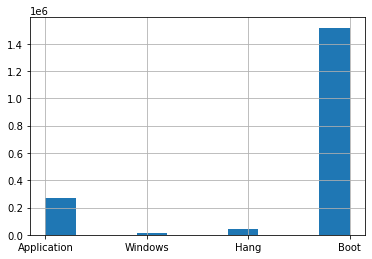

In [46]:
df['error_type'].hist()

In [47]:
print(df.shape)
df.dtypes

(1835089, 173)


level_0                                   int64
index                                   float64
RWB_EVENTRAWRESULTITEM_ID               float64
RWB_ETL_EVENT_DESTINATION_IDENTIFIER      int64
RWB_CREATE_TIMESTAMP                     object
                                         ...   
MachineName                              object
Reason                                   object
param5                                   object
ActionDescription                        object
BootID_formatted                         object
Length: 173, dtype: object

In [48]:
# How many boot events occurred after an INC was filed?
# df[df['error_type'] == 'Boot']['BootID'] - df[df['error_type'] == 'Boot']['opened_at_utc']


# Create 'num_events' feature.


In [57]:
'CreatedSystemTime_CST_formatted' in list(df.columns)

True

In [76]:
# Because 'TimeCreatedSystemTime' never exists in 'df_boot',
# 'CreatedSystemTime_CST_formatted' will always be pd.NaT for Boot events,
# because it is unique to the regular events only.
df[df['error_type'] == 'Boot']['CreatedSystemTime_CST'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns, America/Chicago]

In [74]:
# Create the events feature by grouping by ClientItemKey and the TimeCreatedSystemTime CST date column,
# and get the count of events for each machine each day.
# Boot events excluded by default on basis of the .groupby() columns.

# num_events = df.groupby(['RWB_EFFECTIVE_DATE', 'ClientItemKey']).agg('size').reset_index().rename(columns={0:'events'})
num_events = df.groupby(['ClientItemKey', 'CreatedSystemTime_CST_formatted']).agg('size').reset_index().rename(columns={0:'events'})
num_events

,ClientItemKey,CreatedSystemTime_CST_formatted,events
0,16783564,2023-03-13,1
1,16783564,2023-04-03,2
2,16783835,2023-01-10,1
3,16783835,2023-01-20,1
4,16783835,2023-02-10,1
...,...,...,...
188461,16819018,2023-05-15,1
188462,16819018,2023-06-28,1
188463,16819018,2023-06-30,3
188464,16819021,2023-06-30,1


<AxesSubplot:>

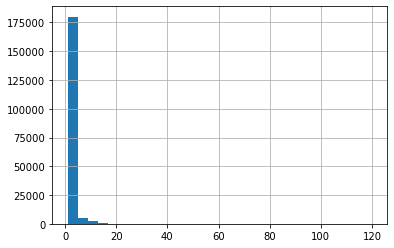

In [66]:
num_events['events'].hist(bins=30)

In [60]:
check_this_df = pd.read_parquet('../do_not_commit/Datasets/num_events.pq')
check_this_df

In [67]:
# Export the result to parquet and save to blob storage.
num_events.to_parquet('../do_not_commit/FeatureDatasets/num_events.pq')


#### How many INCs contain direct reference to BSOD?


In [ ]:
df['short_description_NER'].unique()

In [ ]:
# How many short descriptions talk about BSODs?
len(df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

In [ ]:
# What is the frequency of each error type for BSOD tickets?
df.dropna(subset='short_description_NER')[df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'Combined_Application', 'Combined_dll', 'Combined_Exception']]

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['Combined_Application']

In [ ]:
df.dropna(subset='short_description_NER')[(df.dropna(subset='short_description_NER')['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']


#### What is the distribution of FaultApplicationName among INCs?


In [ ]:
df_check = df[df['error_type'] == 'Application']

In [ ]:
df_check['Combined_Application'].value_counts()


#### What is the distribution of modules among INCs?


In [ ]:
df_check['Combined_dll'].value_counts()


#### Which exception codes are most common among INCs?


In [ ]:
df_check[['Combined_Application', 'Combined_Exception']].value_counts()